In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
import xarray as xr
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.modelzoo.customlstm import CustomLSTM
from neuralhydrology.modelzoo.ealstm import EALSTM
from neuralhydrology.utils.config import Config
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
config_file = Path(
    "./model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/config.yml"
)

cudalstm_config = Config(config_file)

# create a new model instance with random weights
cuda_lstm = CudaLSTM(cfg=cudalstm_config)

# load the trained weights into the new model.
model_path = cudalstm_config.run_dir / "model_epoch024.pt"
model_weights = torch.load(
    str(model_path), map_location="cpu"
)  # load the weights from the file, creating the weight tensors on CPU
cuda_lstm.load_state_dict(
    model_weights
)  # set the new model's weights to the values loaded from file
custom_lstm = CustomLSTM(
    cfg=cudalstm_config
)  # create a new CustomLSTM (with random weights)
custom_lstm.copy_weights(cuda_lstm)  # copy the CudaLSTM weights into the CustomLSTM
# make sure we're in eval mode where dropout is deactivated
custom_lstm.eval()

# load the dataset
scaler = load_scaler(cudalstm_config.run_dir)
dataset = get_dataset(cudalstm_config, is_train=False, period="test", scaler=scaler)
dataloader = DataLoader(
    dataset, batch_size=731, shuffle=False, collate_fn=dataset.collate_fn
)

example_states = custom_lstm(next(iter(dataloader)))
example_states.keys()

dict_keys(['h_n', 'c_n', 'i', 'f', 'g', 'o', 'y_hat'])

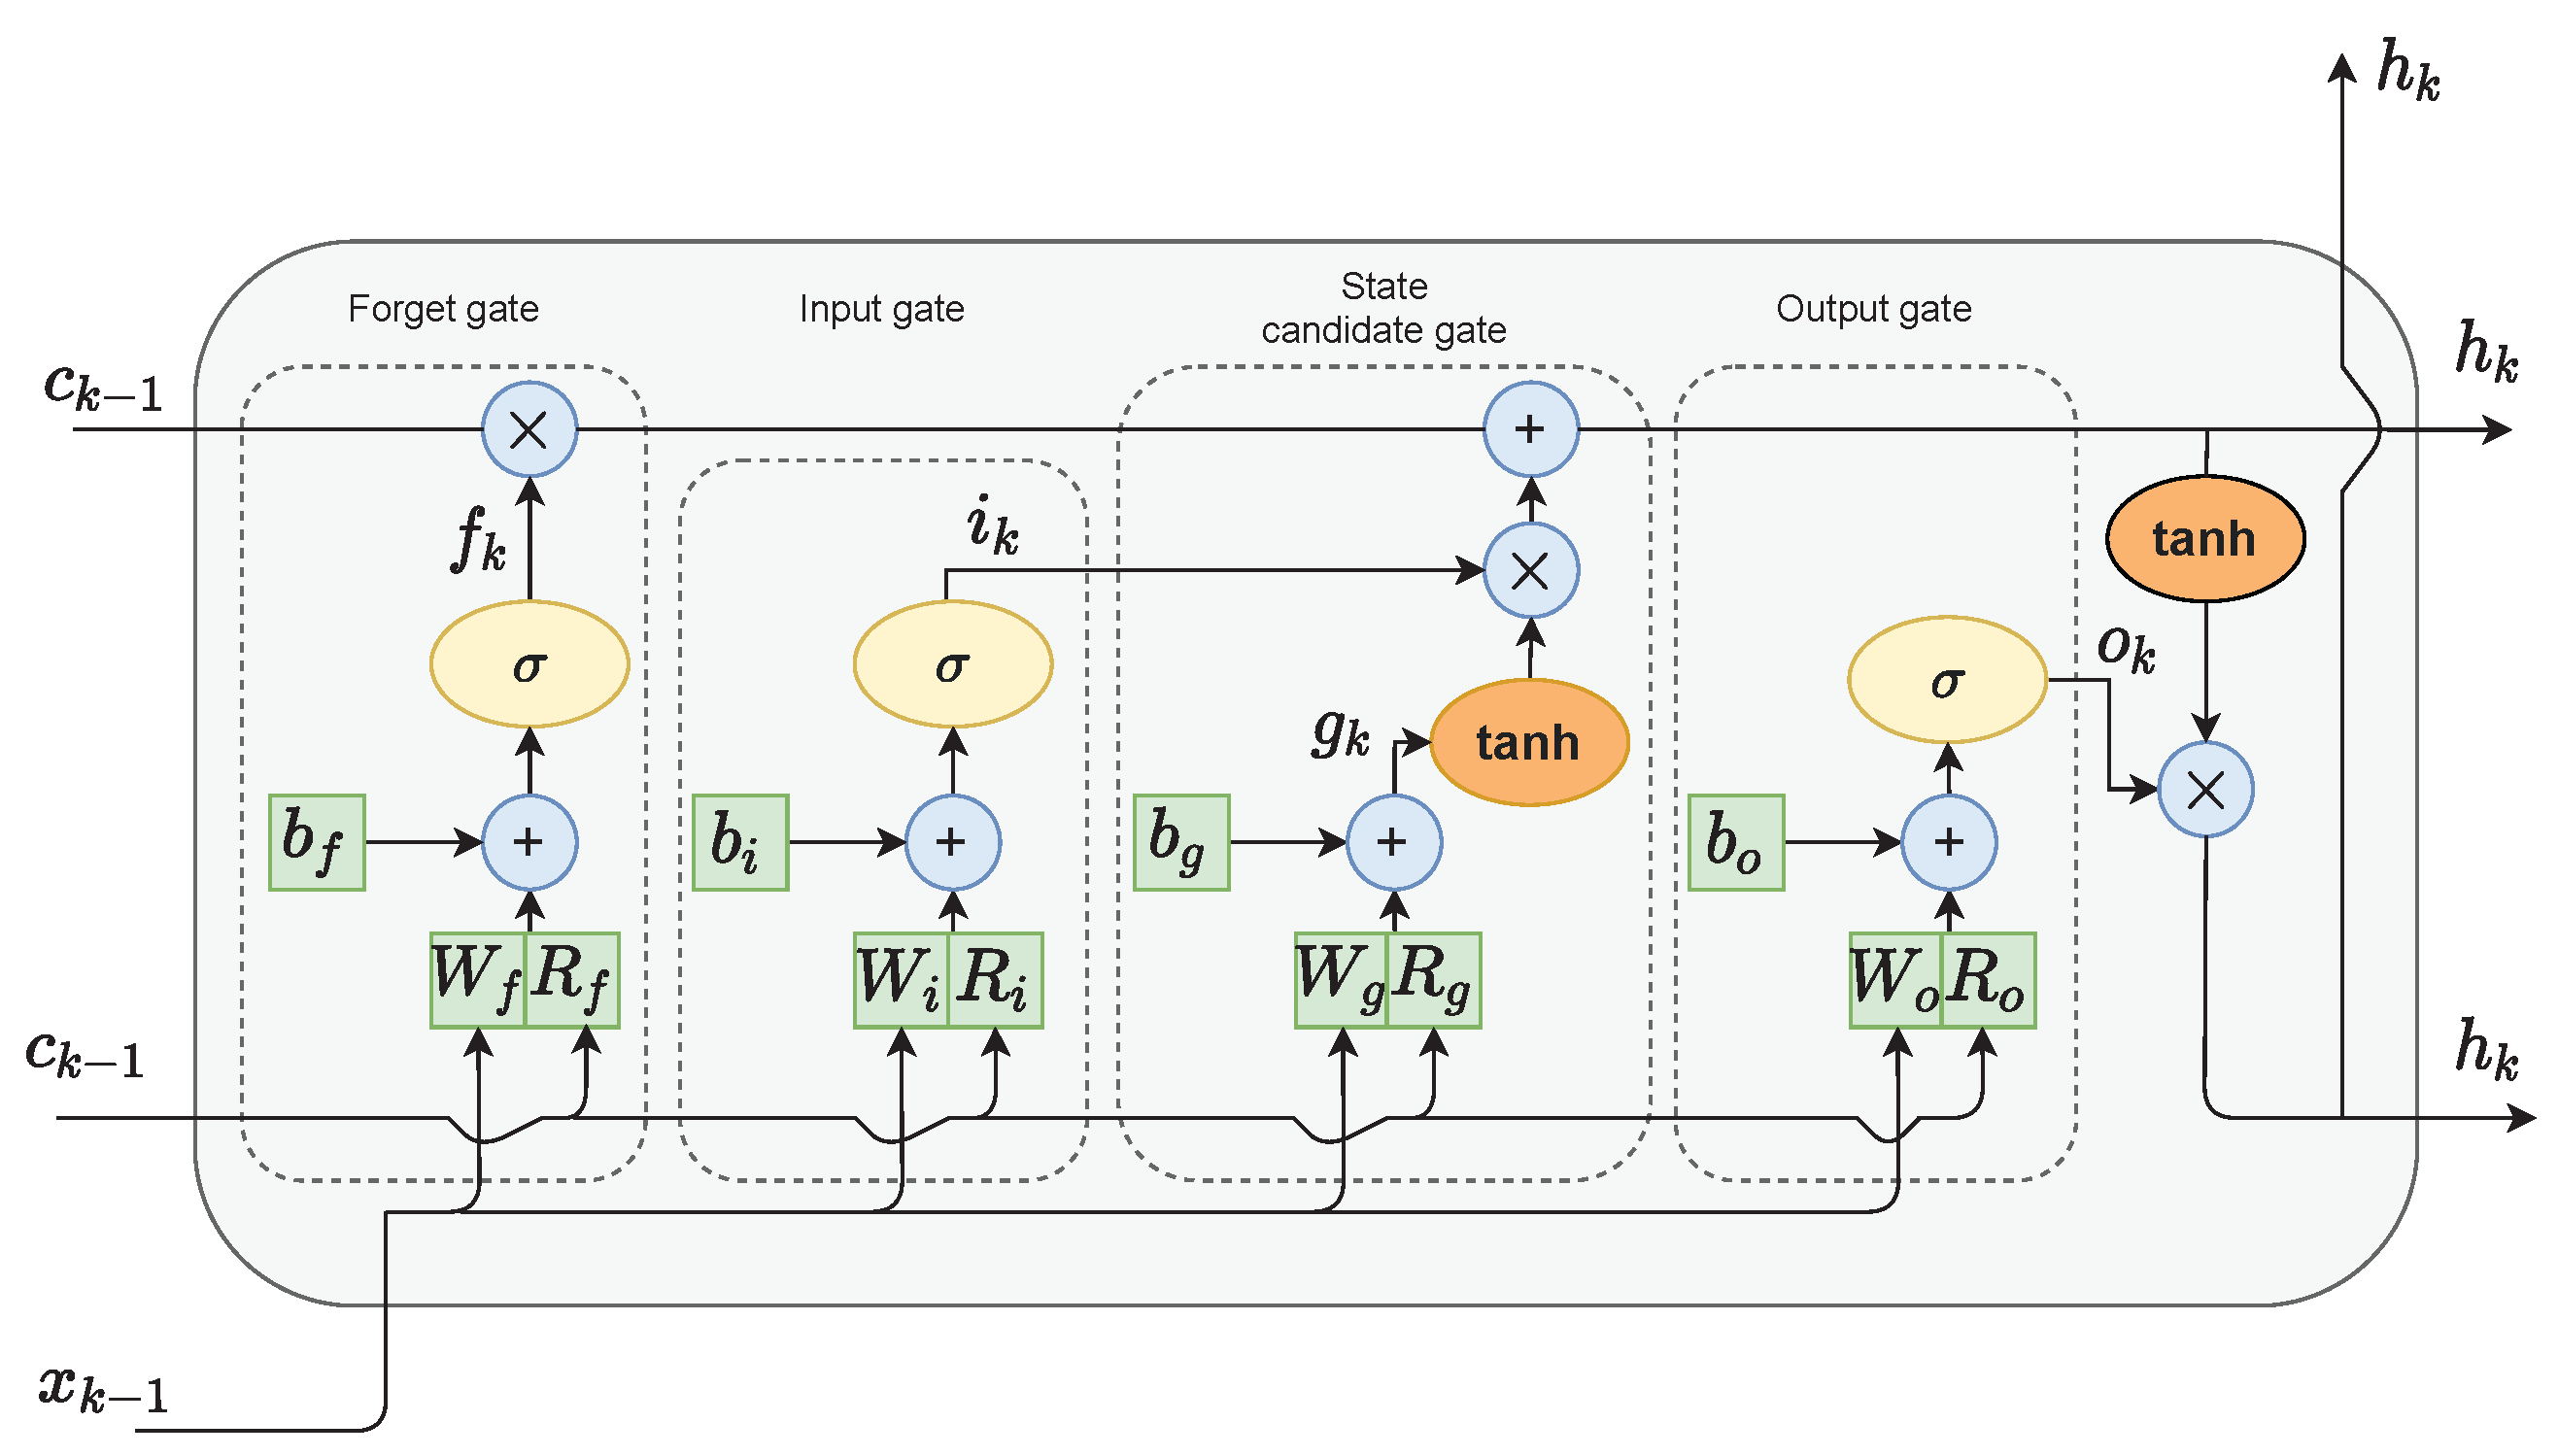
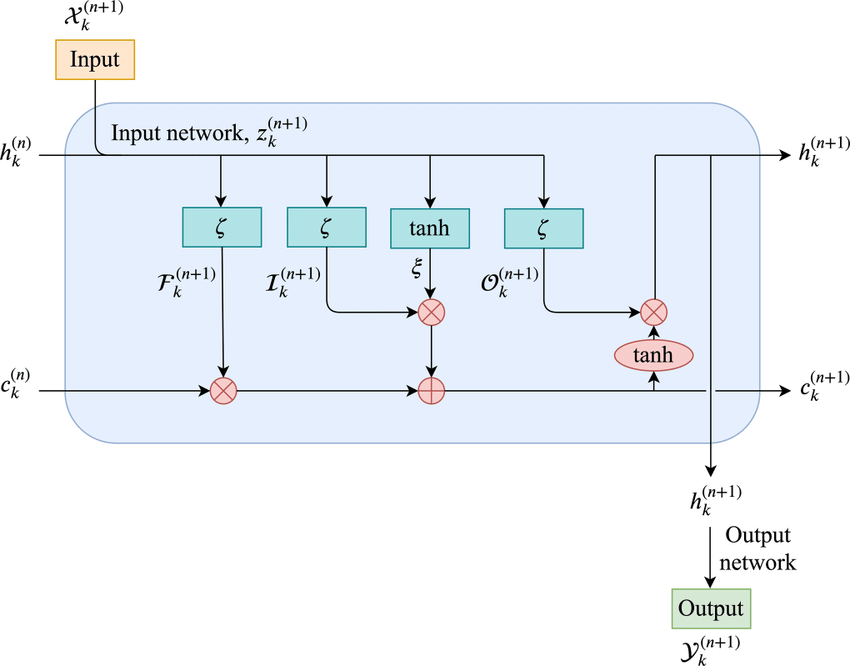

In [203]:
from typing import Tuple


def lstm_layer_correlation(
    state_dict: dict,
    date_range: np.ndarray,
    meteo_array: np.ndarray,
    data_name: str,
    correlation_threshold: float = 0.7,
) -> Tuple[dict, dict]:
    """_summary_.

    Args:
    ----
        state_dict (dict): _description_
        date_range (np.ndarray): _description_
        meteo_array (np.ndarray): _description_

    Returns:
    -------
        Tuple[dict, dict]: _description_

    """
    if len(date_range) != len(meteo_array):
        date_range = date_range[: len(meteo_array)]
    best_correlation = {}
    state_correlation = {}
    for layer in ("c_n", "h_n"):
        # Concatenate all batches into one tensor that contains the final time step of each sample.
        cell_states = torch.cat([state_dict[layer][:, -1, :]], dim=0)
        cell_states = cell_states.detach().numpy()

        # Load the forcings input for the corresponding date range
        corr_data = {}
        state_correlation[layer] = {}
        for i in range(cell_states[:, :].shape[1]):
            state_corr = cell_states[:, i]
            if len(state_corr) != len(meteo_array):
                state_corr = state_corr[: len(meteo_array)]
            corr_coef = np.corrcoef(state_corr, meteo_array)
            corr_coef = corr_coef[0, 1]
            state_correlation[layer][f"{i}"] = corr_coef
            if corr_coef > correlation_threshold:
                corr_data[f"{i}"] = corr_coef

        if len(corr_data) == 0:
            best_correlation[layer] = None
            print(
                f"No states correlated with {data_name} for {layer} with threshold of {correlation_threshold}"
            )
        else:
            cell_value = int(max(corr_data, key=corr_data.get))
            best_correlation[layer] = corr_data[f"{cell_value}"]

            _, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
            # ax.plot(date_range.to_numpy(), cell_states, c="C0", alpha=0.2)

            plot_cell = cell_states[:, cell_value]

            if len(plot_cell) != len(meteo_array):
                plot_cell = plot_cell[: len(meteo_array)]

            ax.plot(date_range, plot_cell, c="red")
            ax.set_ylabel(f"{layer}")
            ax.set_title(
                f" best cell state {cell_value} for {layer} layer, correlation={corr_data[f'{cell_value}']:.2f}",
                fontsize=24,
            )
            ax2.set_ylabel(f"{data_name}")
            ax2.plot(date_range, meteo_array, c="blue")
            plt.tight_layout()

    return (best_correlation, state_correlation)


test_date_range = pd.date_range(
    cudalstm_config.test_start_date,
    cudalstm_config.test_end_date - pd.Timedelta("1D"),
    freq="1D",
)

best_cor, state_cor = lstm_layer_correlation(
    state_dict=example_states,
    date_range=test_date_range.to_numpy(),
    meteo_array=pd.read_csv(
        f"../geo_data/meteo_grids_2024/mswep/precipitation/{gauge_id}.csv",
        index_col="date",
        parse_dates=["date"],
    )
    .loc[test_date_range]
    .to_numpy()
    .ravel(),
    correlation_threshold=0.2,
    data_name="Осадки",
)

No states correlated with Осадки for c_n with threshold of 0.2


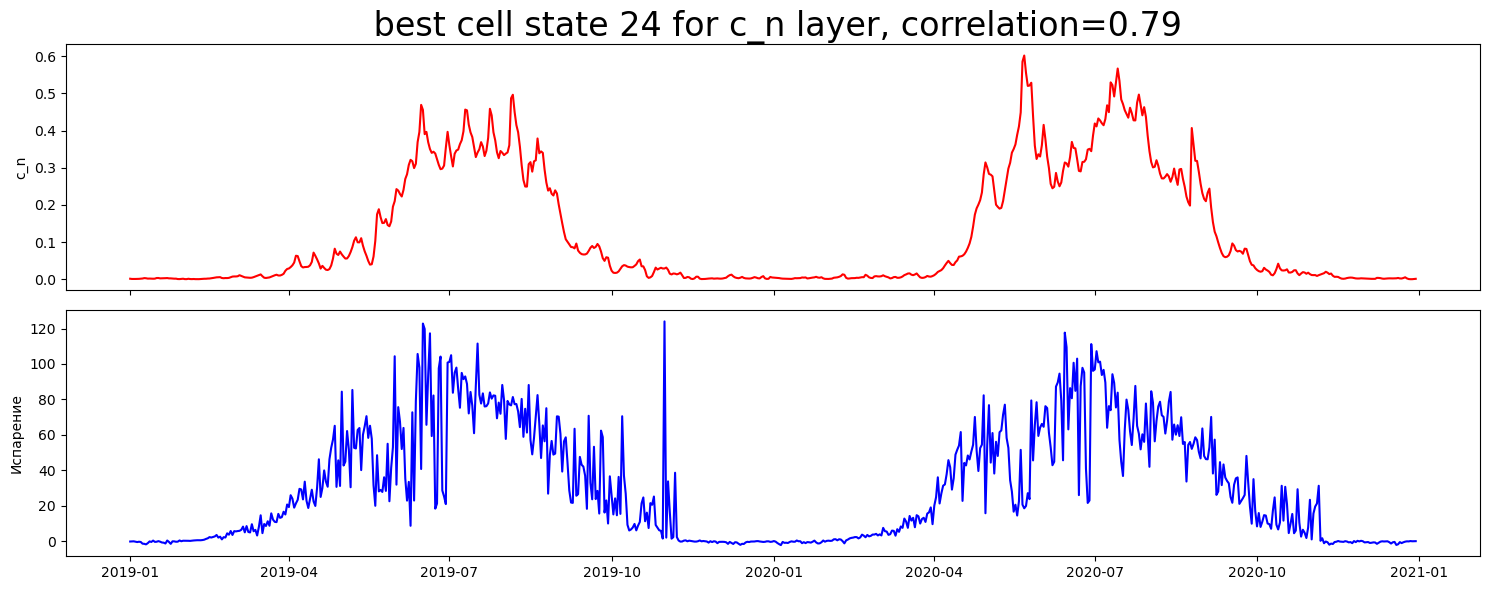

In [204]:
best_cor, state_cor = lstm_layer_correlation(
    state_dict=example_states,
    date_range=test_date_range.to_numpy(),
    meteo_array=pd.read_csv(
        f"../geo_data/meteo_grids_2024/gleam/E/{gauge_id}.csv",
        index_col="date",
        parse_dates=["date"],
    )
    .loc[test_date_range]
    .to_numpy()
    .ravel(),
    correlation_threshold=0.7,
    data_name="Испарение",
)

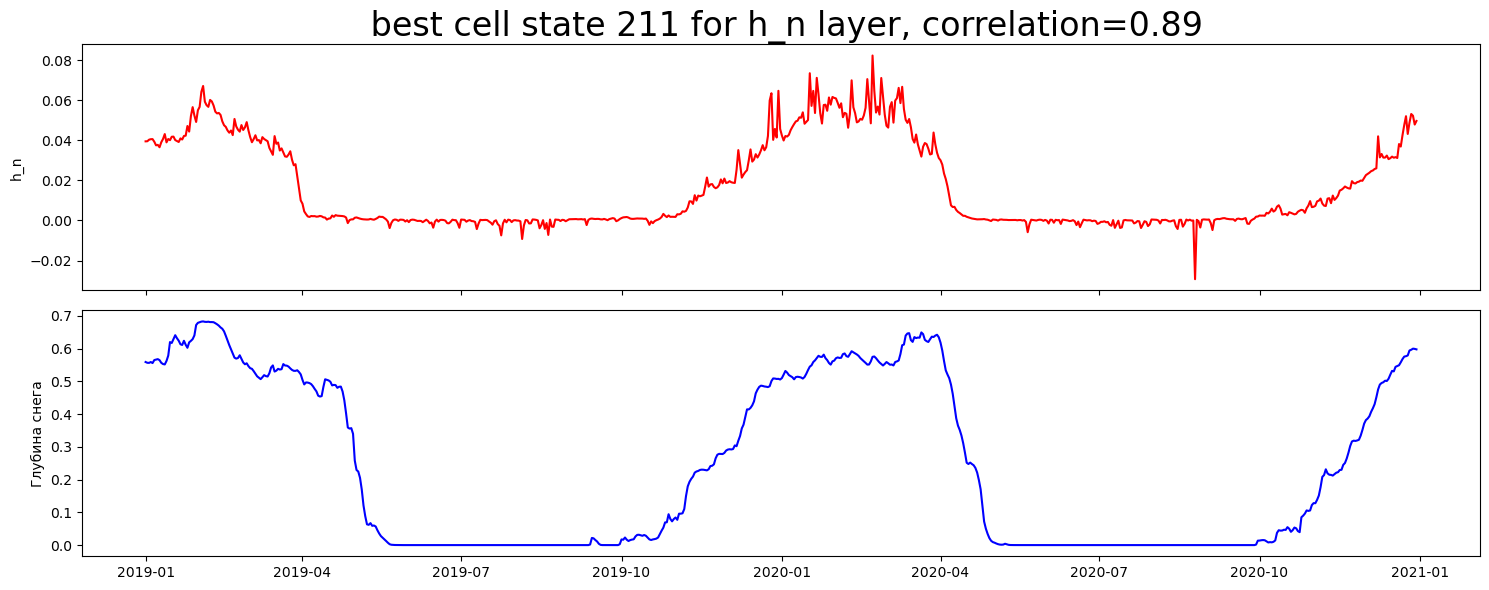

In [208]:
best_cor, state_cor = lstm_layer_correlation(
    state_dict=example_states,
    date_range=test_date_range.to_numpy(),
    meteo_array=pd.read_csv(
        f"../geo_data/snow_and_subsurface/era5_land/snow_depth/{gauge_id}.csv",
        index_col="date",
        parse_dates=["date"],
    )
    .loc[test_date_range]
    .to_numpy()
    .ravel(),
    correlation_threshold=0.7,
    data_name="Глубина снега",
)

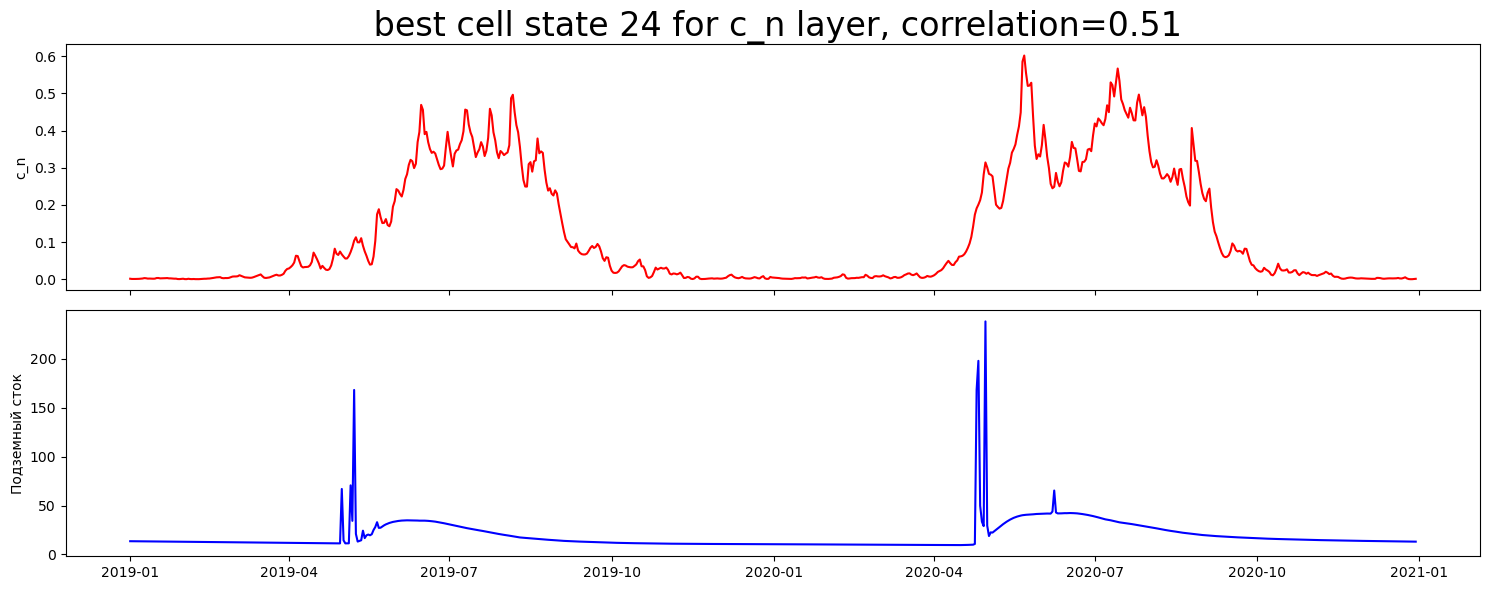

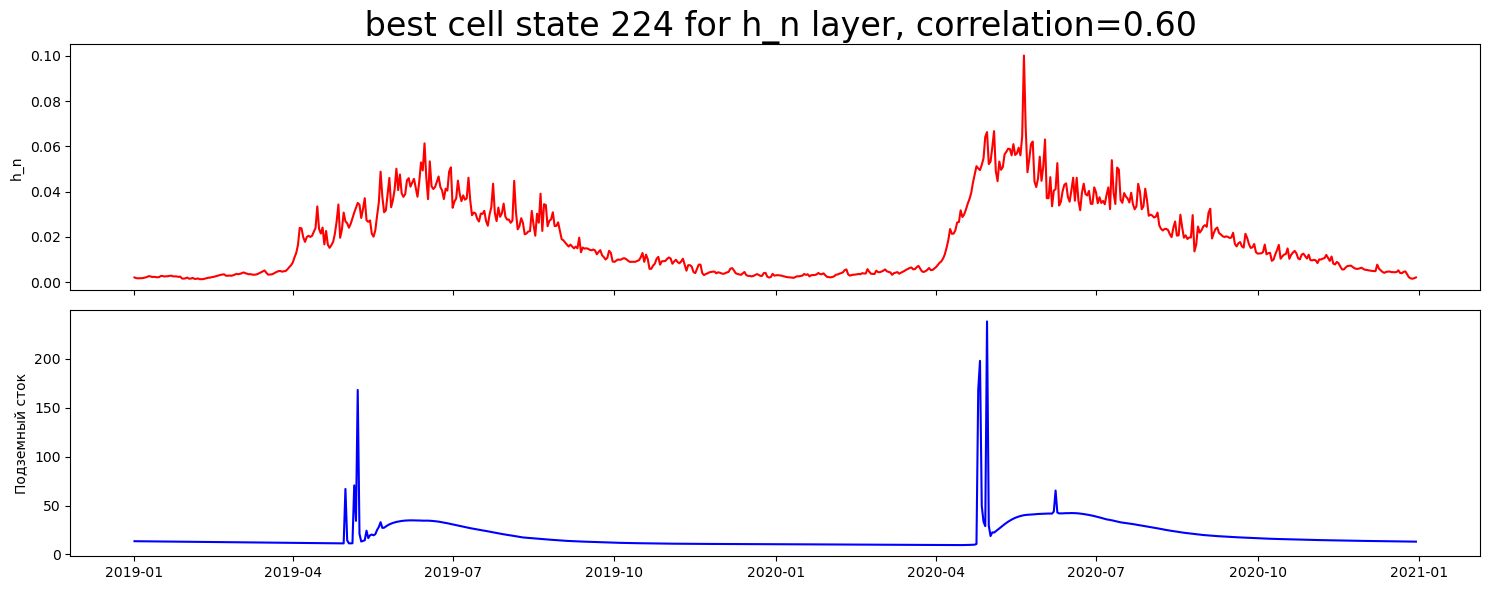

In [210]:
best_cor, state_cor = lstm_layer_correlation(
    state_dict=example_states,
    date_range=test_date_range.to_numpy(),
    meteo_array=pd.read_csv(
        f"../geo_data/snow_and_subsurface/era5_land/sub_surface_runoff/{gauge_id}.csv",
        index_col="date",
        parse_dates=["date"],
    )
    .loc[test_date_range]
    .to_numpy()
    .ravel(),
    correlation_threshold=0.5,
    data_name="Подземный сток",
)

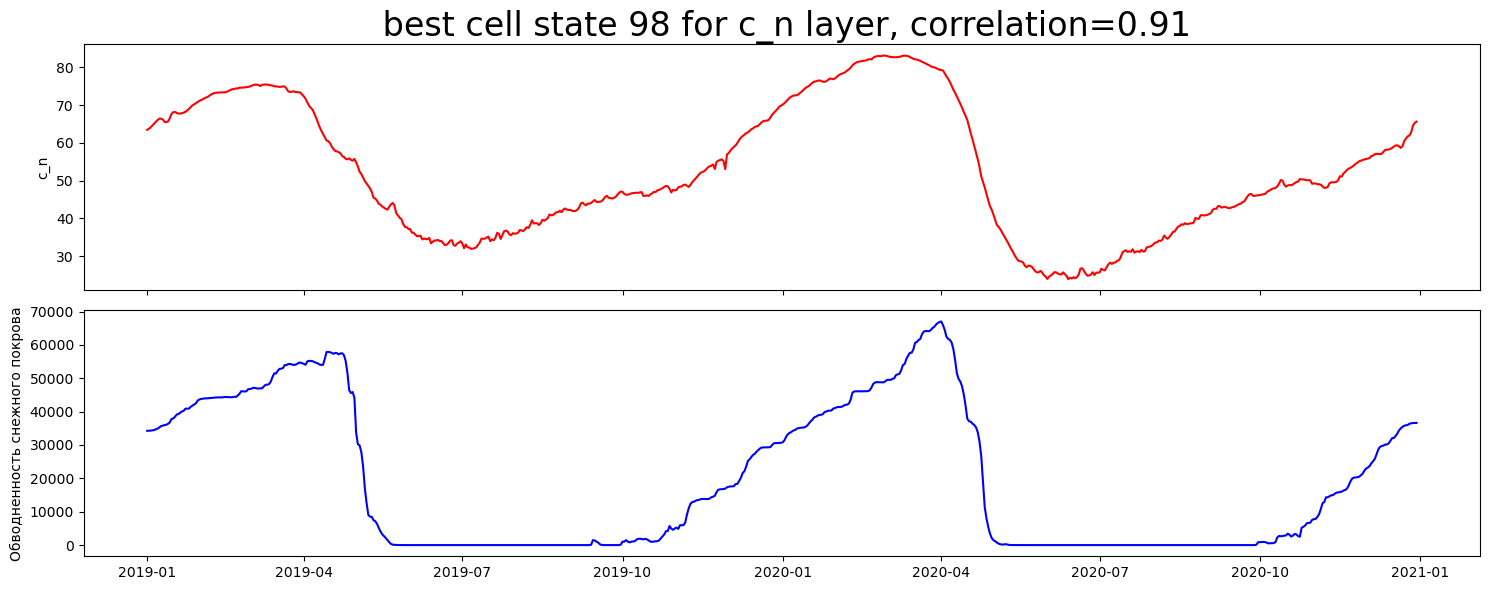

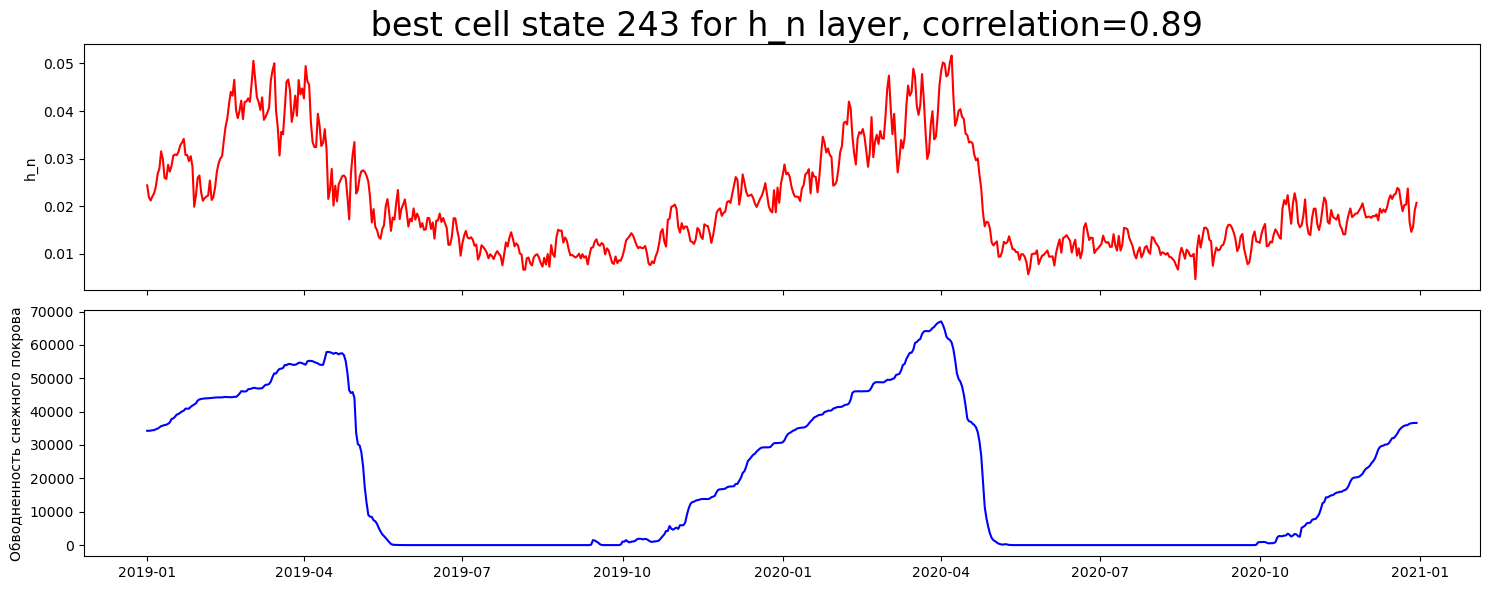

In [211]:
best_cor, state_cor = lstm_layer_correlation(
    state_dict=example_states,
    date_range=test_date_range.to_numpy(),
    meteo_array=pd.read_csv(
        f"../geo_data/snow_and_subsurface/era5_land/snow_depth_water_equivalent/{gauge_id}.csv",
        index_col="date",
        parse_dates=["date"],
    )
    .loc[test_date_range]
    .to_numpy()
    .ravel(),
    correlation_threshold=0.7,
    data_name="Обводненность снежного покрова",
)

In [217]:
res_dict = dict()
for key, val in state_cor["c_n"].items():
    if val > 0.7:
        res_dict[key] = val
    else:
        continue

### Debug function

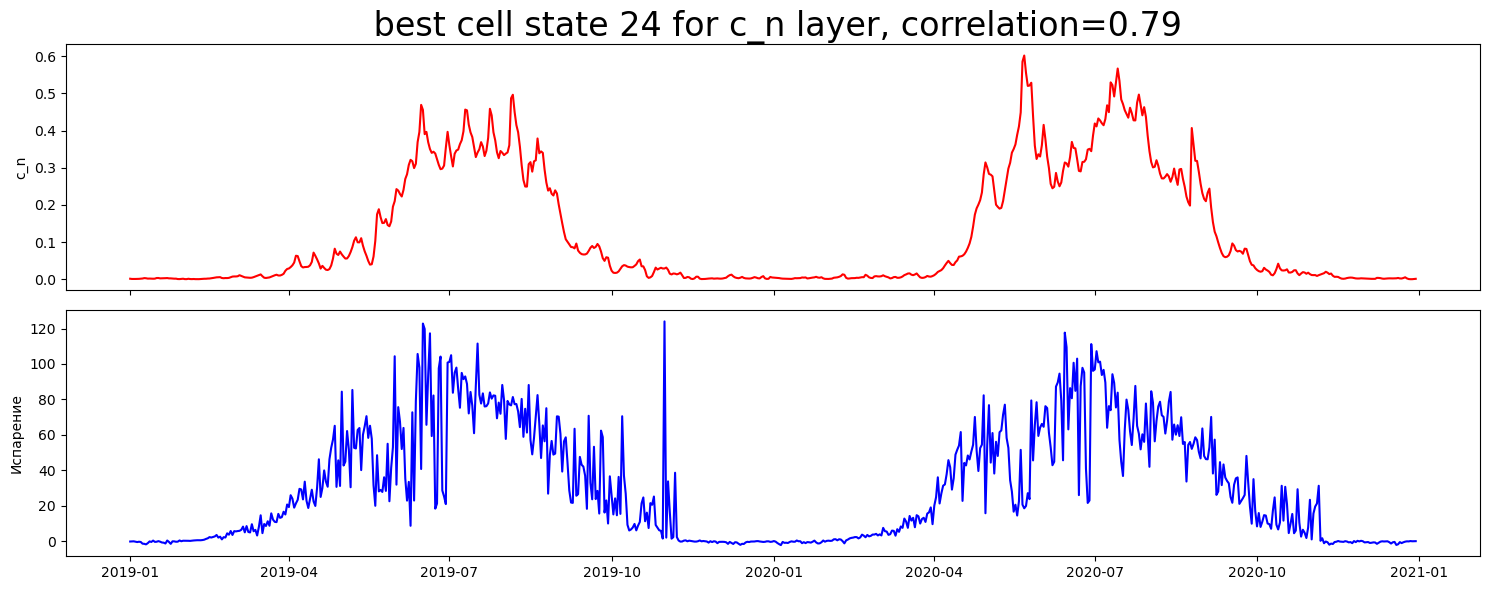

In [205]:
date_range = test_date_range.to_numpy()
meteo_array = (
    pd.read_csv(
        f"../geo_data/meteo_grids_2024/gleam/E/{gauge_id}.csv",
        index_col="date",
        parse_dates=["date"],
    )
    .loc[date_range]
    .to_numpy()
    .ravel()
)
state_dict = example_states
correlation_threshold = 0.7
data_name = "Испарение"

if len(date_range) != len(meteo_array):
    date_range = date_range[: len(meteo_array)]
best_correlation = {}
state_correlation = {}
for layer in ("c_n", "h_n"):
    # Concatenate all batches into one tensor that contains the final time step of each sample.
    cell_states = torch.cat([state_dict[layer][:, -1, :]], dim=0)
    cell_states = cell_states.detach().numpy()

    # Load the forcings input for the corresponding date range
    corr_data = {}
    state_correlation[layer] = {}
    for i in range(cell_states[:, :].shape[1]):
        state_corr = cell_states[:, i]

        if len(state_corr) != len(meteo_array):
            state_corr = state_corr[: len(meteo_array)]
        corr_coef = np.corrcoef(state_corr, meteo_array)
        corr_coef = corr_coef[0, 1]
        state_correlation[layer][f"{i}"] = corr_coef
        if corr_coef > correlation_threshold:
            corr_data[f"{i}"] = corr_coef

    if len(corr_data) == 0:
        best_correlation[layer] = None
        print(
            f"No states correlated with {data_name} for {layer} with threshold of {correlation_threshold}"
        )
    else:
        cell_value = int(max(corr_data, key=corr_data.get))
        best_correlation[layer] = corr_data[f"{cell_value}"]

        _, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
        # ax.plot(date_range.to_numpy(), cell_states, c="C0", alpha=0.2)

        plot_cell = cell_states[:, cell_value]

        if len(plot_cell) != len(meteo_array):
            plot_cell = plot_cell[: len(meteo_array)]

        ax.plot(date_range, plot_cell, c="red")
        ax.set_ylabel(f"{layer}")
        ax.set_title(
            f" best cell state {cell_value} for {layer} layer, correlation={corr_data[f'{cell_value}']:.2f}",
            fontsize=24,
        )
        ax2.set_ylabel(f"{data_name}")
        ax2.plot(date_range, meteo_array, c="blue")
        plt.tight_layout()